## Hypothesis

This project aims to study the hypothesis that regions with high population density are more prone to terror attacks in Myanmar.

In [1]:
import pandas as pd
import os
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import cluster
from libpysal.weights import Queen, Rook, KNN
from esda.moran import Moran
from sklearn.preprocessing import robust_scale
from sklearn.cluster import AgglomerativeClustering
import numpy as np

sns.set(style='whitegrid')
%matplotlib inline

## Note: using the OS library, this notebook will run on any device as long as the data folder is not moved relative to the .ipynb

In [2]:
dirname = os.getcwd()
dirname

'C:\\Users\\andre\\OneDrive\\Desktop\\USC\\SSCI575\\Project4'

## Read files into geodataframes and set projections

**Read terror attack xy table (.csv) into dataframe and convert to geodataframe**

Terror date range: Jan 1, 2015 - Nov 26, 2022

In [3]:
terror_df = pd.read_csv(os.path.join(dirname, "Data\\terror.csv"))
geometry = [Point(xy) for xy in zip(terror_df.longitude, terror_df.latitude)]
crs = ('epsg:4326') #ACLED CRS (data source)
terror_gdf = GeoDataFrame(terror_df, crs = crs, geometry = geometry)
terror_gdf = terror_gdf.to_crs(epsg=24305) #Project CRS. Per https://epsg.io/?q=myanmar%20kind%3APROJCRS

In [4]:
terror_gdf.head(3)

,data_id,iso,event_id_cnty,event_id_no_cnty,event_date,year,time_precision,event_type,sub_event_type,actor1,...,latitude,longitude,geo_precision,source,source_scale,notes,fatalities,timestamp,iso3,geometry
0,9663925,104,MMR42021,42021,18 November 2022,2022,1,Explosions/Remote violence,Shelling/artillery/missile attack,Military Forces of Myanmar (2021-),...,22.7180,95.5473,2,Radio Free Asia; Khit Thit Media,National-Regional,"On 18 November 2022, near Ma Ni Kone village (...",2,1669128215,MMR,POINT (1380291.215 2537496.376)
1,9663953,104,MMR42084,42084,18 November 2022,2022,1,Protests,Peaceful protest,Protesters (Myanmar),...,22.1086,95.1358,2,Myanmar Labour News; Khit Thit Media,National,"On 18 November 2022, on the West Chindwin Rive...",0,1669128215,MMR,POINT (1341419.334 2467143.031)
2,9663980,104,MMR42145,42145,18 November 2022,2022,1,Battles,Armed clash,Military Forces of Myanmar (2021-),...,21.1310,92.3540,2,Myanmar Now; Democratic Voice of Burma,National,"On 18 November 2022, between Wet Kyein (Myo) a...",0,1669128215,MMR,POINT (1056790.225 2345754.159)


**Read district population data into df and join the total population column to the district boundary gdf**

Also, set crs

In [5]:
#Read population dataframe into pandas df
pop_df = pd.read_csv(os.path.join(dirname, 'Data\\pop_adm_2.csv'))

In [6]:
pop_df.columns

Index(['year', 'ISO3', 'ADM0_EN', 'ADM0_PCODE', 'ADM1_EN', 'ADM1_PCODE',
       'ADM2_EN', 'ADM2_PCODE', 'F_TL', 'M_TL', 'T_TL', 'F_00_04', 'F_05_09',
       'F_10_14', 'F_15_19', 'F_20_24', 'F_25_29', 'F_30_34', 'F_35_39',
       'F_40_44', 'F_45_49', 'F_50_54', 'F_55_59', 'F_60_64', 'F_65_69',
       'F_70_74', 'F_75_79', 'F_80_84', 'F_85_89', 'F_90Plus', 'M_00_04',
       'M_05_09', 'M_10_14', 'M_15_19', 'M_20_24', 'M_25_29', 'M_30_34',
       'M_35_39', 'M_40_44', 'M_45_49', 'M_50_54', 'M_55_59', 'M_60_64',
       'M_65_69', 'M_70_74', 'M_75_79', 'M_80_84', 'M_85_89', 'M_90Plus',
       'T_00_04', 'T_05_09', 'T_10_14', 'T_15_19', 'T_20_24', 'T_25_29',
       'T_30_34', 'T_35_39', 'T_40_44', 'T_45_49', 'T_50_54', 'T_55_59',
       'T_60_64', 'T_65_69', 'T_70_74', 'T_75_79', 'T_80_84', 'T_85_89',
       'T_90Plus'],
      dtype='object')

In [7]:
print(len(pop_df))
pop_df['T_TL'].isna().sum()

80


0

In [8]:
#Read district boundary shapefile into geodataframe
dt_gdf = gpd.read_file(os.path.join(dirname, 'Data\DistrictBoundaries\DistrictBoundaries.shp'))
dt_gdf = dt_gdf.to_crs(epsg=24305)
dt_gdf.head()

,OBJECTID,ST,ST_PCODE,DT,DT_PCODE,DT_MMR4,S_ADMIN,PCode_V,geometry
0,0.0,Ayeyarwady,MMR017,Hinthada,MMR017D002,áááºá¹áá¬áááá­á¯ááº,None,9.3,"POLYGON ((1360350.985 2065240.167, 1360711.674..."
1,1.0,Ayeyarwady,MMR017,Labutta,MMR017D004,ááá½áá¹áá¬ááá­á¯ááº,None,9.3,"MULTIPOLYGON (((1366173.997 1757168.684, 13662..."
2,2.0,Ayeyarwady,MMR017,Maubin,MMR017D005,áá¡á°áááºááá­á¯ááº,None,9.3,"POLYGON ((1393141.870 1944376.654, 1393406.699..."
3,3.0,Ayeyarwady,MMR017,Myaungmya,MMR017D003,áá¼á±á¬ááºá¸áá¼ááá­á¯ááº,None,9.3,"POLYGON ((1378067.102 1890161.506, 1378255.867..."
4,4.0,Ayeyarwady,MMR017,Pathein,MMR017D001,áá¯áá­ááºááá­á¯ááº,None,9.3,"MULTIPOLYGON (((1281016.769 1766685.377, 12809..."


In [9]:
dt_gdf.columns

Index(['OBJECTID', 'ST', 'ST_PCODE', 'DT', 'DT_PCODE', 'DT_MMR4', 'S_ADMIN',
       'PCode_V', 'geometry'],
      dtype='object')

In [10]:
#Rename key column to match with population df
dt_gdf =dt_gdf.rename(columns={'DT_PCODE':'ADM2_PCODE'})
#Join fields confirmed via https://data.humdata.org/dataset/cod-ps-mmr

In [11]:
#Attribute join total population per district into the geodataframe
pop_gdf = pd.merge(dt_gdf,pop_df[['ADM2_PCODE','T_TL']],on='ADM2_PCODE', how='left')

In [12]:
pop_gdf.head()

,OBJECTID,ST,ST_PCODE,DT,ADM2_PCODE,DT_MMR4,S_ADMIN,PCode_V,geometry,T_TL
0,0.0,Ayeyarwady,MMR017,Hinthada,MMR017D002,áááºá¹áá¬áááá­á¯ááº,None,9.3,"POLYGON ((1360350.985 2065240.167, 1360711.674...",1167058
1,1.0,Ayeyarwady,MMR017,Labutta,MMR017D004,ááá½áá¹áá¬ááá­á¯ááº,None,9.3,"MULTIPOLYGON (((1366173.997 1757168.684, 13662...",628538
2,2.0,Ayeyarwady,MMR017,Maubin,MMR017D005,áá¡á°áááºááá­á¯ááº,None,9.3,"POLYGON ((1393141.870 1944376.654, 1393406.699...",987219
3,3.0,Ayeyarwady,MMR017,Myaungmya,MMR017D003,áá¼á±á¬ááºá¸áá¼ááá­á¯ááº,None,9.3,"POLYGON ((1378067.102 1890161.506, 1378255.867...",790179
4,4.0,Ayeyarwady,MMR017,Pathein,MMR017D001,áá¯áá­ááºááá­á¯ááº,None,9.3,"MULTIPOLYGON (((1281016.769 1766685.377, 12809...",1649662


## Drop unimportant columns and rename useful columns to intuitive names 

In [13]:
pop_gdf.head(3)

,OBJECTID,ST,ST_PCODE,DT,ADM2_PCODE,DT_MMR4,S_ADMIN,PCode_V,geometry,T_TL
0,0.0,Ayeyarwady,MMR017,Hinthada,MMR017D002,áááºá¹áá¬áááá­á¯ááº,None,9.3,"POLYGON ((1360350.985 2065240.167, 1360711.674...",1167058
1,1.0,Ayeyarwady,MMR017,Labutta,MMR017D004,ááá½áá¹áá¬ááá­á¯ááº,None,9.3,"MULTIPOLYGON (((1366173.997 1757168.684, 13662...",628538
2,2.0,Ayeyarwady,MMR017,Maubin,MMR017D005,áá¡á°áááºááá­á¯ááº,None,9.3,"POLYGON ((1393141.870 1944376.654, 1393406.699...",987219


In [14]:
pop_gdf.columns

Index(['OBJECTID', 'ST', 'ST_PCODE', 'DT', 'ADM2_PCODE', 'DT_MMR4', 'S_ADMIN',
       'PCode_V', 'geometry', 'T_TL'],
      dtype='object')

In [15]:
pop_gdf = pop_gdf.drop(['ST', 'ST_PCODE', 'DT', 'DT_MMR4', 'S_ADMIN', 'PCode_V'], axis=1).rename(columns={'T_TL':'Total Population','terror_ct':"Number of Terror events"})

In [16]:
pop_gdf.sort_values(by=['Total Population'], na_position='first').head()

,OBJECTID,ADM2_PCODE,geometry,Total Population
21,23.0,MMR003D004,"POLYGON ((1597949.032 2088064.538, 1597981.999...",38038
18,18.0,MMR002D002,"POLYGON ((1610974.752 2171553.744, 1611179.340...",51272
13,13.0,MMR004D002,"POLYGON ((1191353.272 2424270.225, 1192186.003...",71649
11,11.0,MMR004D003,"POLYGON ((1151810.134 2565148.010, 1152360.497...",110696
17,17.0,MMR001D004,"POLYGON ((1540266.346 3201468.118, 1539901.260...",111169


## Calculate population density

In [17]:
pop_gdf['Population Density'] = (pop_gdf['Total Population'] / pop_gdf['geometry'].area)
pop_gdf.head(3)

,OBJECTID,ADM2_PCODE,geometry,Total Population,Population Density
0,0.0,MMR017D002,"POLYGON ((1360350.985 2065240.167, 1360711.674...",1167058,0.000164
1,1.0,MMR017D004,"MULTIPOLYGON (((1366173.997 1757168.684, 13662...",628538,0.000167
2,2.0,MMR017D005,"POLYGON ((1393141.870 1944376.654, 1393406.699...",987219,0.000225


(array([77.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.]),
 array([3.90027335e-06, 1.52875362e-03, 3.05360697e-03, 4.57846032e-03,
        6.10331367e-03, 7.62816702e-03, 9.15302037e-03, 1.06778737e-02,
        1.22027271e-02, 1.37275804e-02, 1.52524338e-02]),
 <BarContainer object of 10 artists>)

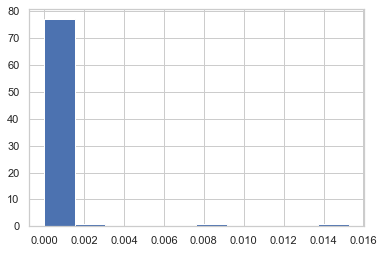

In [18]:
plt.hist(pop_gdf['Population Density'])

In [19]:
pop_gdf.sort_values(by=['Population Density'], ascending=False, na_position='first').head(5)

,OBJECTID,ADM2_PCODE,geometry,Total Population,Population Density
40,83.0,MMR013D004,"MULTIPOLYGON (((1474868.133 1881194.068, 14748...",1167751,0.015252
37,80.0,MMR013D002,"POLYGON ((1495713.721 1905622.100, 1495727.717...",2854432,0.007763
41,32.0,MMR010D001,"POLYGON ((1454596.405 2478900.183, 1455243.239...",1861454,0.001998
38,81.0,MMR013D001,"POLYGON ((1463967.925 1989966.573, 1465086.805...",3125668,0.000659
39,82.0,MMR013D003,"MULTIPOLYGON (((1189013.444 1573682.474, 11891...",1705367,0.000354


## Drop Outliers
3 districts are an order of magnitude larger than the rest. Drop them as outliers

In [ ]:
pop_gdf = pop_gdf.drop([37,40,41]).sort_values(by=['Population Density'], ascending=False, na_position='first')

In [23]:
pop_gdf

,OBJECTID,ADM2_PCODE,geometry,Total Population,Population Density
38,81.0,MMR013D001,"POLYGON ((1463967.925 1989966.573, 1465086.805...",3125668,0.000659
39,82.0,MMR013D003,"MULTIPOLYGON (((1189013.444 1573682.474, 11891...",1705367,0.000354
54,45.0,MMR012D001,"MULTIPOLYGON (((1142676.958 2229732.398, 11428...",859241,0.000274
3,3.0,MMR017D003,"POLYGON ((1378067.102 1890161.506, 1378255.867...",790179,0.000253
62,53.0,MMR005D003,"POLYGON ((1340629.745 2524241.369, 1341180.089...",814273,0.000230
...,...,...,...,...,...
12,12.0,MMR004D004,"POLYGON ((1156067.186 2471818.082, 1156744.551...",165972,0.000012
18,18.0,MMR002D002,"POLYGON ((1610974.752 2171553.744, 1611179.340...",51272,0.000010
30,54.0,MMR005S001,"MULTIPOLYGON (((1308038.043 2871386.892, 13082...",122385,0.000009
21,23.0,MMR003D004,"POLYGON ((1597949.032 2088064.538, 1597981.999...",38038,0.000005


(array([41., 14., 13.,  6.,  1.,  1.,  0.,  0.,  0.,  1.]),
 array([3.90027335e-06, 6.94172936e-05, 1.34934314e-04, 2.00451334e-04,
        2.65968354e-04, 3.31485374e-04, 3.97002395e-04, 4.62519415e-04,
        5.28036435e-04, 5.93553455e-04, 6.59070475e-04]),
 <BarContainer object of 10 artists>)

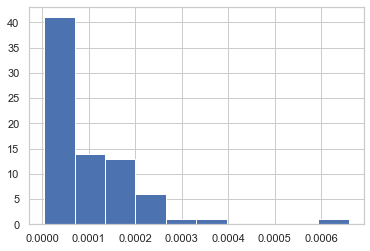

In [25]:
plt.hist(pop_gdf['Population Density'])

**Log transform Population density to achieve a more normal distribution**

In [26]:
pop_gdf['Log_Pop_Den'] = np.log10(pop_gdf['Population Density'])

(array([ 2.,  2.,  8.,  5., 11., 17., 11., 17.,  3.,  1.]),
 array([-5.40890495, -5.18612127, -4.96333759, -4.74055391, -4.51777023,
        -4.29498655, -4.07220287, -3.84941919, -3.62663551, -3.40385182,
        -3.18106814]),
 <BarContainer object of 10 artists>)

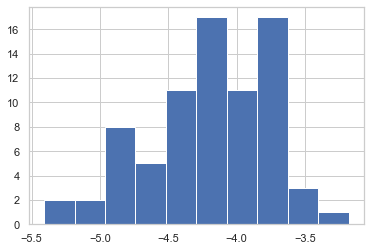

In [27]:
plt.hist(pop_gdf['Log_Pop_Den'])

## Plot districts by population and add terror event points over

In [28]:
#Check extents
print('population bounds: ' + str(pop_gdf.total_bounds))
print('terror bounds: ' + str(terror_gdf.total_bounds))

population bounds: [1037769.01635214 1088207.21383713 1978061.07827107 3203430.53491157]
terror bounds: [1040412.97699957 1125681.24830013 1896214.24477776 3114998.74203196]


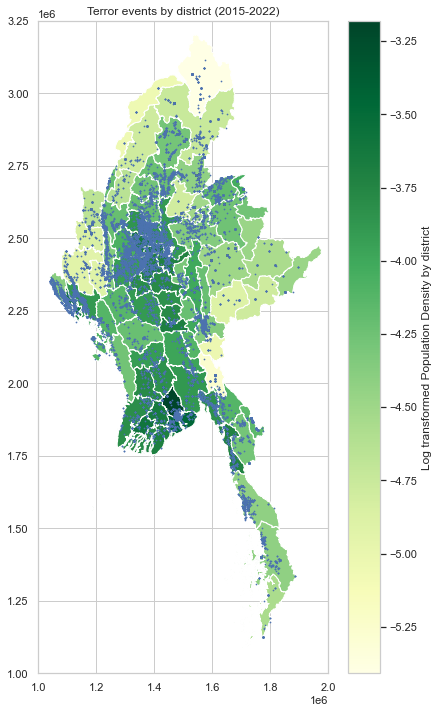

In [29]:
#Plot
fig, ax = plt.subplots(figsize=(7,12), subplot_kw = {'aspect':'equal'})
pop_gdf.plot(column = 'Log_Pop_Den', legend=True, cmap='YlGn', ax=ax, legend_kwds={'label': "Log transformed Population Density by district"})
ax.set_xlim(1000000, 2000000)
ax.set_ylim(1000000, 3250000)
ax.set_title('Terror events by district (2015-2022)')

ax = terror_gdf.plot(ax=ax, markersize = 0.5, legend=True)
# plt.savefig(os.path.join(dirname,'Figures\\StudyArea.png'))

## Spatial Join number of terror events into each district polygon

In [30]:
join_gdf = gpd.sjoin(terror_gdf, pop_gdf, how = 'inner',predicate='intersects')
terror_ct_df = join_gdf.groupby(['ADM2_PCODE'],as_index=False)['data_id'].count()
terror_ct_df.columns=['ADM2_PCODE','terror_ct']
terror_ct_df.sort_values(by=['terror_ct'], ascending=False).head()

,ADM2_PCODE,terror_ct
22,MMR005D009,2199
15,MMR005D002,1698
59,MMR015D002,1678
36,MMR009D004,1428
16,MMR005D003,1277


In [31]:
terror = pop_gdf.merge(terror_ct_df,on='ADM2_PCODE',how='left')
terror.sort_values(by=['terror_ct'], ascending=False).head(3)

,OBJECTID,ADM2_PCODE,geometry,Total Population,Population Density,Log_Pop_Den,terror_ct
31,59.0,MMR005D009,"POLYGON ((1297240.959 2545914.100, 1297774.910...",580764,0.000087,-4.060643,2199
21,57.0,MMR005D002,"POLYGON ((1322393.702 2597618.339, 1322910.108...",1110223,0.000136,-3.867746,1698
36,69.0,MMR015D002,"POLYGON ((1679144.072 2717161.815, 1679093.533...",519549,0.000066,-4.181929,1678


Check for NA values. If they exist, impute with 0

In [32]:
print(terror['terror_ct'].isna().sum())

0


In [33]:
terror['terror_ct'].fillna(value=0, inplace=True)
print(terror['terror_ct'].isna().sum())

0


In [34]:
terror = terror.rename(columns={'terror_ct':"Number of Terror events"})

In [35]:
terror.head(3)

,OBJECTID,ADM2_PCODE,geometry,Total Population,Population Density,Log_Pop_Den,Number of Terror events
0,81.0,MMR013D001,"POLYGON ((1463967.925 1989966.573, 1465086.805...",3125668,0.000659,-3.181068,910
1,82.0,MMR013D003,"MULTIPOLYGON (((1189013.444 1573682.474, 11891...",1705367,0.000354,-3.451365,347
2,45.0,MMR012D001,"MULTIPOLYGON (((1142676.958 2229732.398, 11428...",859241,0.000274,-3.561715,718


## Min-Max scale the count columns 

Geometry column is causing issues during normalization. For that reason, I will:

1.) drop the geometry column to create DataFrame from GeoDataFrame

2.) scale the numeric columns 

3.) Reconnect geometry to recreate GeoDataFrame and drop outliers

In [36]:
terror_df = pd.DataFrame(terror.drop('geometry', axis=1))

In [37]:
print(type(terror_df))

<class 'pandas.core.frame.DataFrame'>


In [38]:
num = terror_df.select_dtypes(include='number')
df_norm = (num - num.min())/(num.max()-num.min())
terror_df[df_norm.columns] = df_norm
terror_df.tail()

,OBJECTID,ADM2_PCODE,Total Population,Population Density,Log_Pop_Den,Number of Terror events
72,0.146341,MMR004D004,0.041434,0.011994,0.215117,0.242369
73,0.219512,MMR002D002,0.004286,0.008702,0.175622,0.022323
74,0.658537,MMR005S001,0.027318,0.007815,0.163445,0.006834
75,0.280488,MMR003D004,0.000000,0.002425,0.066623,0.157175
76,0.207317,MMR001D004,0.023685,0.000000,0.000000,0.091572


In [39]:
dt_gdf.head(3)

,OBJECTID,ST,ST_PCODE,DT,ADM2_PCODE,DT_MMR4,S_ADMIN,PCode_V,geometry
0,0.0,Ayeyarwady,MMR017,Hinthada,MMR017D002,áááºá¹áá¬áááá­á¯ááº,None,9.3,"POLYGON ((1360350.985 2065240.167, 1360711.674..."
1,1.0,Ayeyarwady,MMR017,Labutta,MMR017D004,ááá½áá¹áá¬ááá­á¯ááº,None,9.3,"MULTIPOLYGON (((1366173.997 1757168.684, 13662..."
2,2.0,Ayeyarwady,MMR017,Maubin,MMR017D005,áá¡á°áááºááá­á¯ááº,None,9.3,"POLYGON ((1393141.870 1944376.654, 1393406.699..."


In [41]:
terror_scaled = pd.merge(dt_gdf,terror_df[['ADM2_PCODE','Total Population', 'Number of Terror events','Population Density','Log_Pop_Den']],on='ADM2_PCODE', how='left')
terror_scaled = terror_scaled.drop(columns = ['OBJECTID','ST', 'ST_PCODE', 'DT', 'DT_MMR4', 'S_ADMIN','PCode_V']).drop([37,40,41])
terror_scaled.sort_values(by=['Log_Pop_Den'], ascending=False, na_position='first').head()

,ADM2_PCODE,geometry,Total Population,Number of Terror events,Population Density,Log_Pop_Den
38,MMR013D001,"POLYGON ((1463967.925 1989966.573, 1465086.805...",1.000000,0.412756,1.000000,1.000000
39,MMR013D003,"MULTIPOLYGON (((1189013.444 1573682.474, 11891...",0.540003,0.156264,0.533907,0.878673
54,MMR012D001,"MULTIPOLYGON (((1142676.958 2229732.398, 11428...",0.265965,0.325285,0.412774,0.829140
3,MMR017D003,"POLYGON ((1378067.102 1890161.506, 1378255.867...",0.243598,0.030068,0.380078,0.813292
62,MMR005D003,"POLYGON ((1340629.745 2524241.369, 1341180.089...",0.251402,0.579954,0.345123,0.794789


## Drop additional outlier
Drop ADM2_PCODE = MMR001D004 because the population density == 0 

In [42]:
check = terror_scaled.loc[pop_gdf['ADM2_PCODE'] == 'MMR001D004']
check

,ADM2_PCODE,geometry,Total Population,Number of Terror events,Population Density,Log_Pop_Den
17,MMR001D004,"POLYGON ((1540266.346 3201468.118, 1539901.260...",0.023685,0.091572,0.0,0.0


In [43]:
terror_scaled = terror_scaled.drop([17])

## Visualize spatial distributions of different scaled population, population density, and terror events

In [44]:
cluster_variables = ['Number of Terror events', 'Log_Pop_Den']

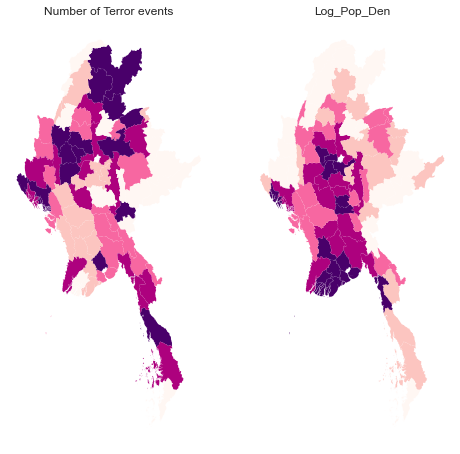

In [45]:
f, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 16))
# Make the axes accessible with single indexing
axs = axs.flatten()
# Start a loop over all the variables of interest
for i, col in enumerate(cluster_variables):
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    terror_scaled.plot(
        column=col,
        ax=ax,
        scheme="Quantiles",
        linewidth=0,
        cmap="RdPu",
    )
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    ax.set_title(col)
# Display the figure
plt.show()

Visual inspection suggests that area with higher population density are **not** more prone to terror attacks.

Let's dig deeper.

## Calculate for global correlation between population density and terror count

In [46]:
terror_scaled['Number of Terror events'].corr(terror_scaled['Log_Pop_Den'])

0.16880675211516763

In [47]:
temp_terr = terror_scaled[['Total Population','Population Density','Log_Pop_Den','Number of Terror events']]

In [48]:
temp_terr.corr()

,Total Population,Population Density,Log_Pop_Den,Number of Terror events
Total Population,1.000000,0.802816,0.735153,0.219085
Population Density,0.802816,1.000000,0.832960,0.120484
Log_Pop_Den,0.735153,0.832960,1.000000,0.168807
Number of Terror events,0.219085,0.120484,0.168807,1.000000


Globally, the number of terror events has a low correlation coefficient with total population, population density, and log-transformed population density.

## Clustering (not spatially explicit)

In [49]:
terror_scaled.sort_values(by=['Log_Pop_Den'], ascending=False, na_position='first')

,ADM2_PCODE,geometry,Total Population,Number of Terror events,Population Density,Log_Pop_Den
38,MMR013D001,"POLYGON ((1463967.925 1989966.573, 1465086.805...",1.000000,0.412756,1.000000,1.000000
39,MMR013D003,"MULTIPOLYGON (((1189013.444 1573682.474, 11891...",0.540003,0.156264,0.533907,0.878673
54,MMR012D001,"MULTIPOLYGON (((1142676.958 2229732.398, 11428...",0.265965,0.325285,0.412774,0.829140
3,MMR017D003,"POLYGON ((1378067.102 1890161.506, 1378255.867...",0.243598,0.030068,0.380078,0.813292
62,MMR005D003,"POLYGON ((1340629.745 2524241.369, 1341180.089...",0.251402,0.579954,0.345123,0.794789
...,...,...,...,...,...,...
13,MMR004D002,"POLYGON ((1191353.272 2424270.225, 1192186.003...",0.010886,0.142141,0.012836,0.224060
12,MMR004D004,"POLYGON ((1156067.186 2471818.082, 1156744.551...",0.041434,0.242369,0.011994,0.215117
18,MMR002D002,"POLYGON ((1610974.752 2171553.744, 1611179.340...",0.004286,0.022323,0.008702,0.175622
30,MMR005S001,"MULTIPOLYGON (((1308038.043 2871386.892, 13082...",0.027318,0.006834,0.007815,0.163445


C:\Users\andre\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


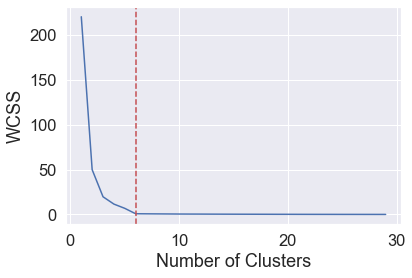

In [60]:
wcss = []
for clusters in range (1,30):
    model = cluster.KMeans(n_clusters=clusters)
    #Fit model to only number of terror events and Log-Transformed Population Density
    model.fit(terror_scaled.drop(['geometry', 'ADM2_PCODE','Total Population','Population Density'], axis=1).values)
    wcss.append(model.inertia_)
x_ax = []
for x in range (1,30):
    x_ax.append(x)
plt.plot(x_ax,wcss)
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.axvline(6, linestyle='--', color='r')

WCSS plot levels off at  k=6

In [52]:
km6 = cluster.KMeans(n_clusters=6)

In [53]:
km6cls = km6.fit(terror_scaled.drop(['geometry', 'ADM2_PCODE','Total Population','Population Density'], axis=1).values)

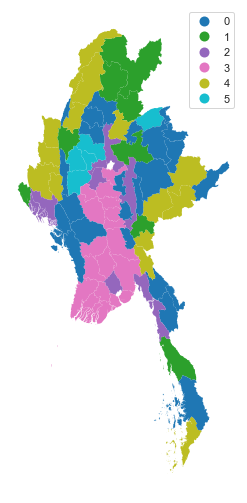

In [54]:
terror_scaled['km6cls']=km6cls.labels_
f, ax = plt.subplots(1,figsize=(9,9))
terror_scaled.plot(column='km6cls',categorical=True, legend=True, linewidth=0, ax=ax)
ax.set_axis_off()
plt.show()

In [55]:
# Group data table by cluster label and count observations
k6sizes = terror_scaled.groupby("km6cls").size()
k6sizes

km6cls
0    22
1     8
2     9
3    18
4    14
5     5
dtype: int64

In [56]:
# Group table by cluster label, keep the variables used
# for clustering, and obtain their mean
km6means = terror_scaled.groupby("km6cls")[cluster_variables].mean()
# Transpose the table and print it rounding each value
# to three decimals
km6means.T.round(3)

km6cls,0,1,2,3,4,5
Number of Terror events,0.110,0.452,0.304,0.087,0.070,0.753
Log_Pop_Den,0.509,0.454,0.758,0.735,0.258,0.662


In [58]:
# Index db on cluster ID
tidy_db = terror_scaled.set_index("km6cls")
# Keep only variables used for clustering
tidy_db = tidy_db[cluster_variables]
# Stack column names into a column, obtaining
# a "long" version of the dataset
tidy_db = tidy_db.stack()
# Take indices into proper columns
tidy_db = tidy_db.reset_index()
# Rename column names
tidy_db = tidy_db.rename(
    columns={"level_1": "Attribute", 0: "Values"}
)
# Check out result
tidy_db.head()

,km6cls,Attribute,Values
0,3,Number of Terror events,0.067882
1,3,Log_Pop_Den,0.728476
2,3,Number of Terror events,0.029613
3,3,Log_Pop_Den,0.731834
4,3,Number of Terror events,0.057403


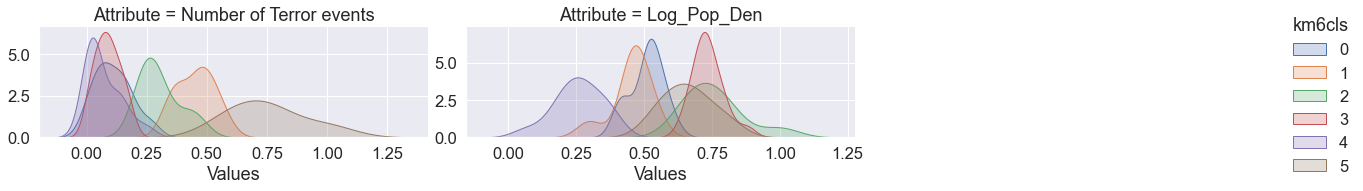

In [61]:
# Scale fonts to make them more readable
sns.set(font_scale=1.5)
# Setup the facets
facets = sns.FacetGrid(
    data=tidy_db,
    col="Attribute",
    hue="km6cls",
    sharey=False,
    sharex=False,
    aspect=2,
    col_wrap=3,
)
# Build the plot from `sns.kdeplot`
_ = facets.map(sns.kdeplot, "Values", shade=True).add_legend()

The Facet's map shows that the number of terror events in most clusters appear to reach a maximum a at different values. The log-transformed population density is more similar across all clusters. There doesn't seem to be a particularly close alignment between the distribution of population density and number of terror events in each spatially inexplcit cluster.

## Regionalization (spatially explicit)

Drop columns from terror_scaled

In [62]:
terror_scaled.columns

Index(['ADM2_PCODE', 'geometry', 'Total Population', 'Number of Terror events',
       'Population Density', 'Log_Pop_Den', 'km6cls'],
      dtype='object')

In [63]:
terror_scaled = terror_scaled.drop(columns=['ADM2_PCODE', 'Total Population','Population Density'])
terror_scaled.columns

Index(['geometry', 'Number of Terror events', 'Log_Pop_Den', 'km6cls'], dtype='object')

Queens case spatial contiguity

In [64]:
w = Queen.from_dataframe(terror_scaled)

In [65]:
cluster_variables = ['Number of Terror events', 'Log_Pop_Den']

In [66]:
# Calculate Moran's I for each variable
mi_results = [Moran(terror_scaled[variable], w) for variable in cluster_variables]
# Structure results as a list of tuples
mi_results = [(variable, res.I, res.p_sim) for variable, res in zip(cluster_variables, mi_results)]
# Display on table
table = pd.DataFrame(
    mi_results, columns=["Variable", "Moran's I", "P-value"]
).set_index("Variable")
table

,Moran's I,P-value
Variable,,
Number of Terror events,0.347220,0.002
Log_Pop_Den,0.526152,0.001


In [67]:
print(table)

                         Moran's I  P-value
Variable                                   
Number of Terror events   0.347220    0.002
Log_Pop_Den               0.526152    0.001


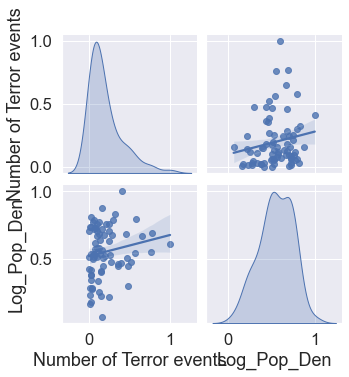

In [68]:
_ = sns.pairplot(terror_scaled[cluster_variables], kind="reg", diag_kind="kde")

In [72]:
terror_scaled.head(3)

,geometry,Number of Terror events,Log_Pop_Den,km6cls
0,"POLYGON ((1360350.985 2065240.167, 1360711.674...",0.067882,0.728476,3
1,"MULTIPOLYGON (((1366173.997 1757168.684, 13662...",0.029613,0.731834,3
2,"POLYGON ((1393141.870 1944376.654, 1393406.699...",0.057403,0.790569,3


In [73]:
terror_agg = robust_scale(terror_scaled[cluster_variables])

In [75]:
# Specify cluster model with queen's case spatial constraint
model = AgglomerativeClustering(linkage="ward", connectivity=w.sparse, n_clusters=6)
# Fit algorithm to the data
model.fit(terror_agg)

AgglomerativeClustering(connectivity=<76x76 sparse matrix of type '<class 'numpy.float64'>'
	with 374 stored elements in Compressed Sparse Row format>,
                        n_clusters=6)

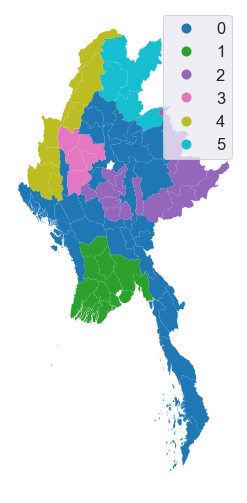

In [105]:
terror_scaled["ward6wq"] = model.labels_
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
terror_scaled.plot(
    column="ward6wq",
    categorical=True,
    legend=True,
    linewidth=0,
    ax=ax,
)
# Remove axis
ax.set_axis_off()
# Display the map
plt.show()

## Create a df from each unique region where there are more than 1 district

In [81]:
reg0 = terror_scaled.loc[terror_scaled['ward6wq'] == 0]
reg1 = terror_scaled.loc[terror_scaled['ward6wq'] == 1]
reg2 = terror_scaled.loc[terror_scaled['ward6wq'] == 2]
reg3 = terror_scaled.loc[terror_scaled['ward6wq'] == 3]
reg4 = terror_scaled.loc[terror_scaled['ward6wq'] == 4]
reg5 = terror_scaled.loc[terror_scaled['ward6wq'] == 5]

## Calculate Moran's I and P- value for each region with more than 1 district

In [110]:
def Morans_(region_df, region_num):
    terror = region_df.loc[region_df['ward6wq'] == region_num]
    w = Queen.from_dataframe(terror)
    mi_results = [Moran(terror[variable],w) for variable in cluster_variables]
    mi_results = [(variable, res.I, res.p_sim) for variable, res in zip(cluster_variables, mi_results)]
    table = pd.DataFrame(mi_results, columns=["Variable", "Moran's I", "P-value"]).set_index("Variable")
    return table

**Region 0**

In [111]:
Morans_(reg0,0)

,Moran's I,P-value
Variable,,
Number of Terror events,0.126557,0.131
Log_Pop_Den,0.293257,0.009


**Region 1**

In [112]:
Morans_(reg1,1)

,Moran's I,P-value
Variable,,
Number of Terror events,0.030366,0.203
Log_Pop_Den,0.066947,0.183


**Region 2**

In [113]:
Morans_(reg2,2)

,Moran's I,P-value
Variable,,
Number of Terror events,0.475496,0.019
Log_Pop_Den,0.650342,0.003


**Region 3**

In [114]:
Morans_(reg3,3)

,Moran's I,P-value
Variable,,
Number of Terror events,-0.491602,0.053
Log_Pop_Den,-0.004950,0.156


**Region 4**

In [115]:
Morans_(reg4,4)

,Moran's I,P-value
Variable,,
Number of Terror events,0.639405,0.002
Log_Pop_Den,0.293474,0.053


**Region 5**

In [116]:
Morans_(reg5,5)

,Moran's I,P-value
Variable,,
Number of Terror events,-0.423941,0.420
Log_Pop_Den,-0.240163,0.408


## Calculate correlation coefficient or ratio for each region individually

In [117]:
terror_scaled.columns

Index(['geometry', 'Number of Terror events', 'Log_Pop_Den', 'km6cls',
       'ward6wq', 'ratio'],
      dtype='object')

In [118]:
terror_scaled['ratio'] = terror_scaled['Number of Terror events'] / terror_scaled['Log_Pop_Den']

In [119]:
terror_scaled.sort_values(by=['ward6wq'])

,geometry,Number of Terror events,Log_Pop_Den,km6cls,ward6wq,ratio
79,"POLYGON ((1690726.366 2643041.548, 1691174.023...",0.200456,0.516570,0,0,0.388051
33,"POLYGON ((1531089.412 2496441.310, 1531517.307...",0.247380,0.631310,2,0,0.391852
36,"MULTIPOLYGON (((1720785.858 1291186.358, 17211...",0.178132,0.442853,0,0,0.402238
31,"POLYGON ((1404767.494 2483235.091, 1405913.545...",0.299317,0.790702,2,0,0.378546
78,"POLYGON ((1586093.604 2616497.815, 1586812.161...",0.523007,0.472548,1,0,1.106780
...,...,...,...,...,...,...
30,"MULTIPOLYGON (((1308038.043 2871386.892, 13082...",0.006834,0.163445,4,4,0.041811
71,"POLYGON ((1679144.072 2717161.815, 1679093.533...",0.762642,0.550748,5,5,1.384740
16,"POLYGON ((1504668.936 3038608.167, 1505307.543...",0.476082,0.298442,1,5,1.595225
15,"POLYGON ((1427749.991 2922786.651, 1427778.580...",0.469248,0.505524,1,5,0.928242


In [120]:
i=0
dict_of_cor = {'region':[],'correlation coefficient':[]}
while i<6:
    temp_terr = terror_scaled.loc[terror_scaled['ward6wq'] == i]
    if len(temp_terr) > 1:
        corr = temp_terr['Number of Terror events'].corr(temp_terr['Log_Pop_Den'])
        dict_of_cor['region'].append(i)
        dict_of_cor['correlation coefficient'].append(corr)
        print ("The correlation coefficient between Number of Terror Events and Population Density for region " + str(i) + " is: " + str(corr) + "\n" )
    else:
        if temp_terr.iloc[0,2] == 0:
            print ("This region has a population of 0 \n")
        else: 
            ratio = float(temp_terr['ratio'])
            print("The Number of Terror Events to Population Density ratio for region " + str(i) + " is: " + str(ratio) + "\n")
    i += 1

The correlation coefficient between Number of Terror Events and Population Density for region 0 is: 0.2708242696957384

The correlation coefficient between Number of Terror Events and Population Density for region 1 is: 0.584739088398149

The correlation coefficient between Number of Terror Events and Population Density for region 2 is: 0.5575864045750044

The correlation coefficient between Number of Terror Events and Population Density for region 3 is: -0.20067196995522513

The correlation coefficient between Number of Terror Events and Population Density for region 4 is: -0.24287623718771215

The correlation coefficient between Number of Terror Events and Population Density for region 5 is: 0.5134165064072143



**To remind ourselves of the global correlation coefficient:**

In [121]:
terror_scaled['Number of Terror events'].corr(terror_scaled['Log_Pop_Den'])

0.16880675211516763

In [123]:
corr_df = pd.DataFrame.from_dict(dict_of_cor)
print("The average correlation coefficient after regionalization is: " + str(corr_df['correlation coefficient'].mean()))
corr_df

The average correlation coefficient after regionalization is: 0.24716967698886147


,region,correlation coefficient
0,0,0.270824
1,1,0.584739
2,2,0.557586
3,3,-0.200672
4,4,-0.242876
5,5,0.513417
